# Uso de Transformers para clasificación de texto.

Vamos a hacer uso de transformers ya que estos funcionan especialmente bien para el tratamiento del texto y para modelos de clasificación de este. Estos se encargan de Tokenizar el texto conservando informaciones relevantes como el contexto o el orden de las palabras. Cosas que con otras técnicas como TF-IDF no es posible.

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("fake_news_dataset.csv")

# BERT tiene en cuenta [SEP] como separador de texto
df_reducido = df[["title", "text", "label"]].copy()
df_reducido["combined"] = df_reducido["title"] + " [SEP] " + df_reducido["text"]
df_reducido['label'] = df_reducido['label'].map({'fake': 0, 'real': 1})
df_reducido.drop(columns=["title", "text"], inplace=True)

display(df_reducido.head())

,label,combined
0,1,Foreign Democrat final. [SEP] more tax develop...
1,0,To offer down resource great point. [SEP] prob...
2,0,Himself church myself carry. [SEP] them identi...
3,0,You unit its should. [SEP] phone which item ya...
4,0,Billion believe employee summer how. [SEP] won...


Ahora una vez preparado nuestro dataframe para poder usar un BERT base vamos a preparar los datos para el entrenamiento.

In [4]:
# Dividir en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(
    df_reducido["combined"].tolist(), df_reducido["label"].tolist(), test_size=0.2
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=1e-8)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

              precision    recall  f1-score   support

           0       0.51      0.12      0.20      2002
           1       0.50      0.88      0.64      1998

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.42      4000
weighted avg       0.50      0.50      0.42      4000



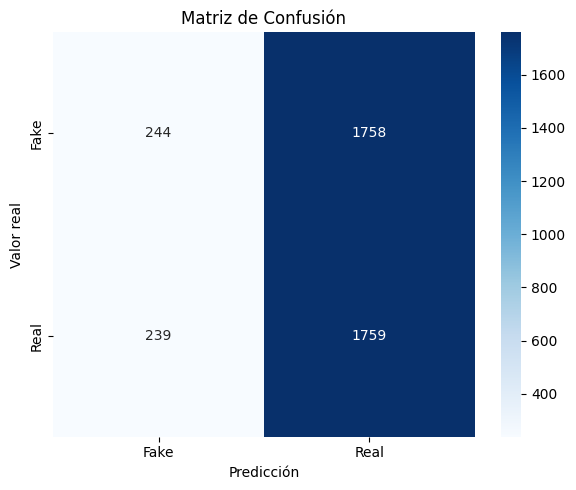

In [6]:
test_loader = DataLoader(test_dataset, batch_size=16)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# Etiquetas opcionales si tus clases no son solo 0 y 1
labels = ["Fake", "Real"]  # reemplázalo si usas otras clases

# Dibujar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

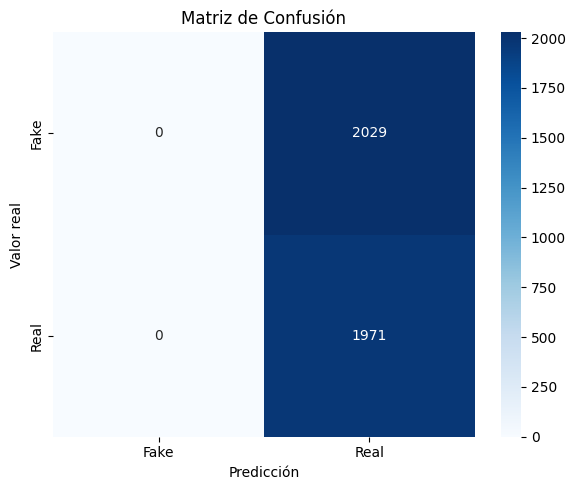

In [15]:
# Obtener predicciones del val_dataset
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
# Etiquetas opcionales si tus clases no son solo 0 y 1
labels = ["Fake", "Real"]  # reemplázalo si usas otras clases

# Dibujar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


In [7]:
# Dividir en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(
    df_reducido["combined"].tolist(), df_reducido["label"].tolist(), test_size=0.2
)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2036
           1       0.49      1.00      0.66      1964

    accuracy                           0.49      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.24      0.49      0.32      4000



/home/pelli/Master/aiiotFakeNews/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pelli/Master/aiiotFakeNews/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pelli/Master/aiiotFakeNews/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

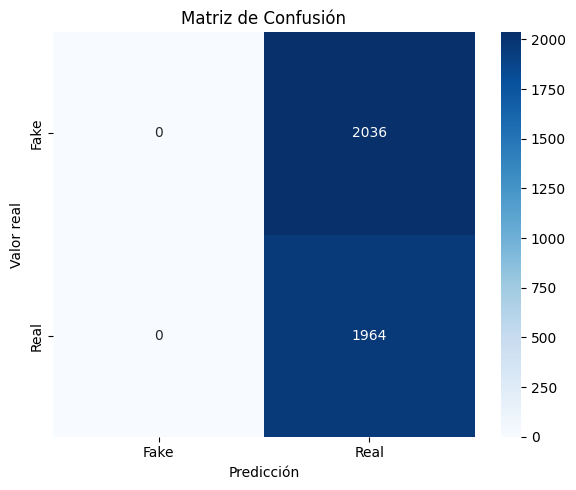

In [11]:
test_loader = DataLoader(test_dataset, batch_size=16)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# Etiquetas opcionales si tus clases no son solo 0 y 1
labels = ["Fake", "Real"]  # reemplázalo si usas otras clases

# Dibujar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()